In [129]:
library(dplyr)
library(ggplot2)
library(tibble)
library(DOSE)
library(wesanderson)
library(pheatmap)
library(EnhancedVolcano)
library(preprocessCore)
library(stringr)
library(ggforce)
library(corrplot)
library(factoextra)
library(RColorBrewer)
library(ComplexHeatmap)
library(circlize)
library(ggpubr)

## Hela cells

In [130]:
data_positive <- read.csv("../Data/Hela/raw_pos.csv")
data_negative <- read.csv("../Data/Hela/raw_neg.csv")

In [131]:
data_positive <- select(data_positive, Name, Formula, 
                        Annot..Source..Predicted.Compositions, 
                        Annot..Source..mzCloud.Search, 
                        Annot..Source..Metabolika.Search, 
                        Annot..Source..ChemSpider.Search, Group.Area..CONTROL_2_pos:Group.Area..CONTROL_1_pos)

data_negative <- select(data_negative, Name, Formula, 
                        Annot..Source..Predicted.Compositions, 
                        Annot..Source..mzCloud.Search, 
                        Annot..Source..Metabolika.Search, 
                        Annot..Source..ChemSpider.Search, Group.Area..CONTROL_2_neg:Group.Area..CONTROL_1_neg)

In [132]:
data_positive <- data_positive[data_positive$Name != "",]
data_negative <- data_negative[data_negative$Name != "",]

In [133]:
new_colnames <- c('Name', 
                  'Formula', 
                  'Predicted.Compositions', 
                             'mzCloud.Search', 
                             'Metabolika.Search', 
                             'ChemSpider.Search',  
                             'CONTROL_2', 
                             'WT_1', 
                             'KO_1', 
                             'WT_6', 
                             'KO_5', 
                             'WT_5', 
                             'KO_6',
                             'WT_4',
                             'KO_3',
                             'WT_3',
                             'KO_2',
                             'WT_2',
                             'KO_4',
                             'CONTROL_1')

colnames(data_positive) <- new_colnames
colnames(data_negative) <- new_colnames

In [134]:
data_positive <- select(data_positive, Name, Formula, 
                        Predicted.Compositions, 
                        mzCloud.Search, 
                        Metabolika.Search, 
                        ChemSpider.Search, 
                        WT_1, WT_2, WT_3, WT_4, WT_5, WT_6, 
                        KO_1, KO_2, KO_3, KO_4, KO_5, KO_6, CONTROL_1, CONTROL_2)

data_negative <- select(data_negative, Name, Formula, 
                        Predicted.Compositions, 
                        mzCloud.Search, 
                        Metabolika.Search, 
                        ChemSpider.Search, 
                        WT_1, WT_2, WT_3, WT_4, WT_5, WT_6, 
                        KO_1, KO_2, KO_3, KO_4, KO_5, KO_6, CONTROL_1, CONTROL_2)

In [135]:
data_positive$blank <- pmax(data_positive$CONTROL_1, data_positive$CONTROL_2)
data_negative$blank <- pmax(data_negative$CONTROL_1, data_negative$CONTROL_2)

In [136]:
data_positive[,7:18] <- data_positive[,7:18]-data_positive[,21]
data_negative[,7:18] <- data_negative[,7:18]-data_negative[,21]

## Filtering metabolites

We will utilize two different strategies to filter features in pos- and neg- datasets:

* **Strict rule** (Full match in all databases)
* **Lightweight rule** (Full match in any database out of 4 available)

Strict rule

In [137]:
databases <- c("Predicted.Compositions", "mzCloud.Search", "Metabolika.Search", "ChemSpider.Search")
data_pos.strict <- data_positive %>% filter_at(vars(all_of(databases)), all_vars(. %in% c("Full match")))
data_neg.strict <- data_negative %>% filter_at(vars(all_of(databases)), all_vars(. %in% c("Full match")))

In [138]:
data_pos.strict <- data_pos.strict[,-c(3:6, 19:21)]
data_neg.strict <- data_neg.strict[,-c(3:6, 19:21)]

Lightweight rule

In [139]:
data_pos.light <- data_positive %>% filter_all(any_vars(. %in% c("Full match")))
data_neg.light <- data_negative %>% filter_all(any_vars(. %in% c("Full match")))

In [140]:
data_pos.light <- data_pos.light[,-c(3:6, 19:21)]
data_neg.light <- data_neg.light[,-c(3:6, 19:21)]

Convert all negative values to NAs

In [141]:
data_pos.strict <- data_pos.strict %>% mutate(across(WT_1:KO_6, ~ replace(., . <0, NA)))
data_neg.strict <- data_neg.strict %>% mutate(across(WT_1:KO_6, ~ replace(., . < 0, NA)))

In [142]:
data_pos.light <- data_pos.light %>% mutate(across(WT_1:KO_6, ~ replace(., . < 0, NA)))
data_neg.light <- data_neg.light %>% mutate(across(WT_1:KO_6, ~ replace(., . < 0, NA)))

Remove all the columns whith more than one NA

In [143]:
na.sum <- apply(data_pos.light, 1, function(r) sum(is.na(r)))
data_pos.light <- data_pos.light[na.sum < 1,]

In [144]:
na.sum <- apply(data_neg.light, 1, function(r) sum(is.na(r)))
data_neg.light <- data_neg.light[na.sum < 1,]

In [145]:
na.sum <- apply(data_pos.strict, 1, function(r) sum(is.na(r)))
data_pos.strict <- data_pos.strict[na.sum < 1,]

In [146]:
na.sum <- apply(data_neg.strict, 1, function(r) sum(is.na(r)))
data_neg.strict <- data_neg.strict[na.sum < 1,]

Create meta file with sample description

In [147]:
genotype <- c(rep('WT', 6), rep('KO', 6))

In [148]:
meta <- data.frame(Genotype = genotype, row.names = colnames(data_pos.strict)[3:14])

Remove WT_1 and WT_10 samples

In [149]:
data_pos.light <- data_pos.light[, -c(3,12)]
data_neg.light <- data_neg.light[, -c(3,12)]

In [150]:
data_pos.strict <- data_pos.strict[, -c(3,12)]
data_neg.strict <- data_neg.strict[, -c(3,12)]

Filter duplicate metabolite entries

In [151]:
removeDupl <- function(df, duplicated_names){
    out <- filter(df, !(Name %in% duplicated_names))
    for (name in duplicated_names){
        df.dupl <- filter(df, Name %in% name)
        cv <- apply(df.dupl[, c(3:12)], 1, function(r) {
                    wt.rep <- r[meta$Genotype == 'WT']
                    ko.rep <- r[meta$Genotype == 'KO']
                    cv_wt <- sd(wt.rep)/mean(wt.rep) * 100
                    cv_ko <- sd(ko.rep)/mean(ko.rep) * 100
                    (cv_wt+cv_ko)/3
        })
        out <- rbind(out, df.dupl[which.min(cv), ])
    }
    
    return(out)
}

Strict rule:

In [152]:
dup.pos <- unique(data_pos.strict[duplicated(data_pos.strict$Name),]$Name)
dup.neg <- unique(data_neg.strict[duplicated(data_neg.strict$Name),]$Name)

In [153]:
data_pos.strict <- removeDupl(data_pos.strict, dup.pos)
data_neg.strict <- removeDupl(data_neg.strict, dup.neg)

In [154]:
data_pos.strict$Name <- paste(data_pos.strict$Name, "(pos)")
data_neg.strict$Name <- paste(data_neg.strict$Name, "(neg)")

In [155]:
data.strict <- rbind(data_pos.strict, data_neg.strict)

Lightweight rule:

In [156]:
dup.pos <- unique(data_pos.light[duplicated(data_pos.light$Name),]$Name)
dup.neg <- unique(data_neg.light[duplicated(data_neg.light$Name),]$Name)

In [157]:
data_pos.light <- removeDupl(data_pos.light, dup.pos)
data_neg.light <- removeDupl(data_neg.light, dup.neg)

In [158]:
data_pos.light$Name <- paste(data_pos.light$Name, "(pos)")
data_neg.light$Name <- paste(data_neg.light$Name, "(neg)")

In [159]:
data.light <- rbind(data_pos.light, data_neg.light)

In [160]:
row.names(data.light) <- NULL
row.names(data.strict) <- NULL

In [161]:
data.light <- column_to_rownames(data.light[, c(1, 3:ncol(data.light))], var = "Name")
data.strict <- column_to_rownames(data.strict[, c(1, 3:ncol(data.strict))], var = "Name")

Filter by CoV (< 40)

In [162]:
cv.light <- apply(data.light, 1, function(r) {
                    wt.rep <- r[meta$Genotype == 'WT']
                    ko.rep <- r[meta$Genotype == 'KO']
                    cv_wt <- sd(wt.rep, na.rm = TRUE)/mean(wt.rep, na.rm = TRUE) * 100
                    cv_ko <- sd(ko.rep, na.rm = TRUE)/mean(ko.rep, na.rm = TRUE) * 100
                    max(cv_wt,cv_ko)
})

cv.strict <- apply(data.strict, 1, function(r) {
                    wt.rep <- r[meta$Genotype == 'WT']
                    ko.rep <- r[meta$Genotype == 'KO']
                    cv_wt <- sd(wt.rep, na.rm = TRUE)/mean(wt.rep, na.rm = TRUE) * 100
                    cv_ko <- sd(ko.rep, na.rm = TRUE)/mean(ko.rep, na.rm = TRUE) * 100
                    max(cv_wt,cv_ko)
})

In [163]:
data.light <- data.light[cv.light < 40,]
data.strict <- data.strict[cv.strict < 40,]

Normalization

In [164]:
MedianNorm <- function(x){
    x/median(x)
}

SumNorm <- function(x){
    x/sum(x)
}

QuantNorm <- function(x){
    normalize.quantiles(as.matrix(x), keep.names = T)
}


NoNorm <- function(x){
    x
}

In [165]:
data.light.norm <- as.data.frame(t(apply(t(data.light), 1, NoNorm)))
data.light.norm1 <- as.data.frame(t(apply(t(data.light), 1, SumNorm)))

In [166]:
data.light.log <- log2(data.light.norm)
data.light.log1 <- log2(data.light.norm1)

In [167]:
rownames(data.light.log) <- c('WT-1', 'WT-2', 'WT-3', 'WT-4', 'WT-5', 
                              'KO-1', 'KO-2', 'KO-3', 'KO-4', 'KO-5')
rownames(data.light.norm) <- rownames(data.light.log)

In [168]:
meta <- meta[-c(1,10),, drop = FALSE]
rownames(meta) <- rownames(data.light.log)

Principal Component Analysis

In [169]:
meta$Genotype <- factor(c(rep('WT', 5), rep('S6KO', 5)), levels = c('WT', 'S6KO'))

In [170]:
plotPCA.mystyle <- function(pca)
{
    d1 <- data.frame(PC1 = pca$x[, 1], PC2 = pca$x[, 2], Genotype = meta$Genotype)
    percentVar <- pca$sdev^2/sum(pca$sdev^2)
    
    hull_cyl <- d1 %>%
      dplyr::group_by(Genotype) %>%
      dplyr::slice(chull(PC1, PC2))
    
    p1 <- ggplot(data = d1, aes_string(x = "PC1", y = "PC2")) +
        geom_point(color = "black", size = 5.6) +
        geom_point(aes_string(color = "Genotype"), size = 5) +
        xlim(-20,20)+ylim(-20,20)+
        geom_mark_ellipse(aes(fill = Genotype), linetype = 0) +
        scale_color_manual(values=c("steelblue", "#8b0000"))+
        scale_fill_manual(values=c("steelblue", "#8b0000"))+
        xlab(paste0("PC1: ", round(percentVar[1] * 100), "% variance")) +
        ylab(paste0("PC2: ", round(percentVar[2] * 100), "% variance")) + 
        theme_dose(font.size = 24)+
        theme(legend.position= c(0.82, 0.896), 
              legend.key = element_rect(colour = NA, fill = NA), 
              legend.title = element_blank(), 
              legend.text=element_text(size=16))

    p1
} 

In [171]:
pca.res <- prcomp(data.light.log, scale=TRUE)

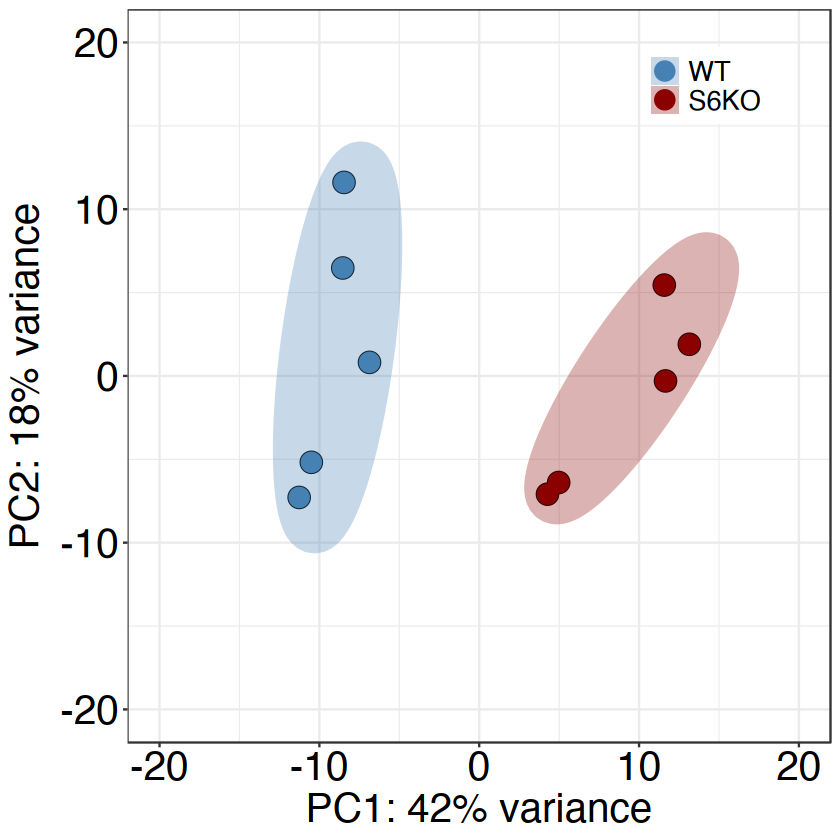

In [172]:
plotPCA.mystyle(pca.res)

In [173]:
var <- get_pca_var(pca.res)

In [174]:
f1 <- fviz_contrib(pca.res, choice = "var", axes = 1, top = 10) + 
        theme(plot.margin=grid::unit(c(10,10,10,28), "mm"))

In [175]:
f1$data <- f1$data %>% arrange(desc(contrib)) %>% head(10)

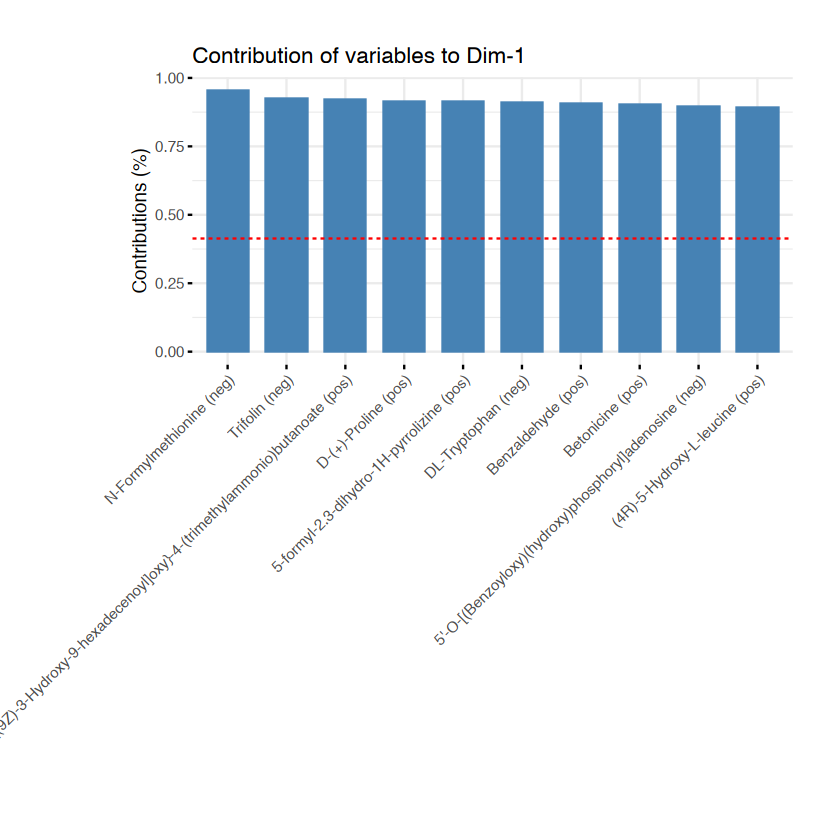

In [176]:
f1

In [177]:
f1$data$name <- c("N-Formylmethionine", 
                  "Trifolin", 
                  "3-Hydroxy-9-hexadecenoylcarnitine",
                  "Proline",
                  "5-formyl-2.3-dihydro-1H-pyrrolizine", 
                  "Tryptophan", 
                  "Benzaldehyde",
                  "Betonicine",
                  "5'-Benzoylphosphoadenosine",
                  "(4R)-5-Hydroxy-L-leucine")

In [178]:
df.impact <- f1$data

In [179]:
df.impact$name <- factor(df.impact$name, levels = rev(df.impact$name))

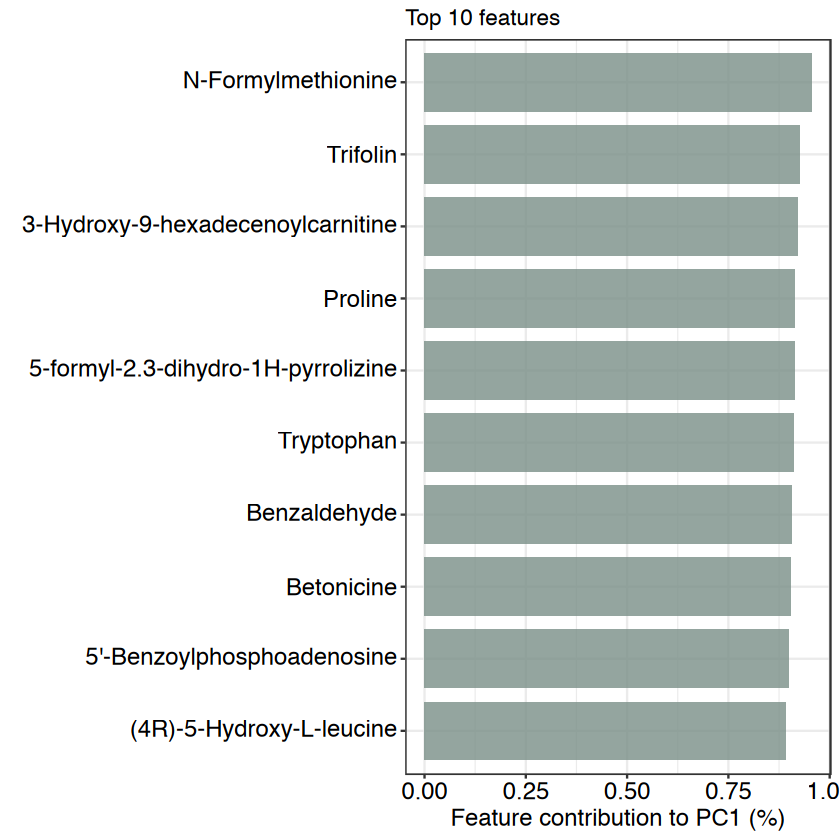

In [180]:
ggplot(df.impact, aes(x = contrib, y = name)) +
    geom_bar(stat='identity', fill = wes_palette("Moonrise2")[1], width = 0.8, alpha = 0.8)+
    xlab('Feature contribution to PC1 (%)')+
    scale_y_discrete(labels=c("Tryptophan" = expression(bold("Tryptophan")), parse=TRUE))+
    ggtitle("Top 10 features")+
    #scale_y_continuous(limits = c(0.5, 1.31), breaks = seq(0.5, 1.3, 0.2))+
    theme_dose(14)+ylab(NULL)

Statistical testing

In [181]:
p.values <- apply(data.light.norm, 2, function(r) {
    wilcox.test(r[c(1:5)], r[c(6:10)])$p.value
})

In [182]:
p.values <- apply(data.light.norm, 2, function(r) {
    t.test(r[c(1:5)], r[c(6:10)])$p.value
})

In [183]:
p.adj.df <- p.adjust(p.values, method = "fdr")

In [184]:
l2fc <- apply(data.light.norm, 2, function(r) {
    log2(mean(r[c(6:10)])) - log2(mean(r[c(1:5)]))
})

In [185]:
res <- data.frame(padj = p.adj.df, log2FoldChange = l2fc) 

In [186]:
res2 <- res

In [187]:
res2$Sig <- 'NS'
res2[((res2$padj < 0.05) & (res2$log2FoldChange < 0)), c(3)] <- 'Down'
res2[((res2$padj < 0.05) & (res2$log2FoldChange > 0)), c(3)] <- 'Up'

In [188]:
names.keyvals <- res2$Sig
names.keyvals[names.keyvals == 'NS'] <- 'grey'
names.keyvals[names.keyvals == 'Down'] <- wes_palette("IsleofDogs1")[1]
names.keyvals[names.keyvals == 'Up'] <- wes_palette("IsleofDogs2")[3]
names(names.keyvals) <- res2$Sig

In [189]:
names <- rownames(res2)
names <- replace(names, names=="DL-Tryptophan (neg)", "Tryptophan")
rownames(res2) <- names

In [190]:
res2['Tryptophan',]

,padj,log2FoldChange,Sig
,<dbl>,<dbl>,<chr>
Tryptophan,0.001502315,0.4409513,Up


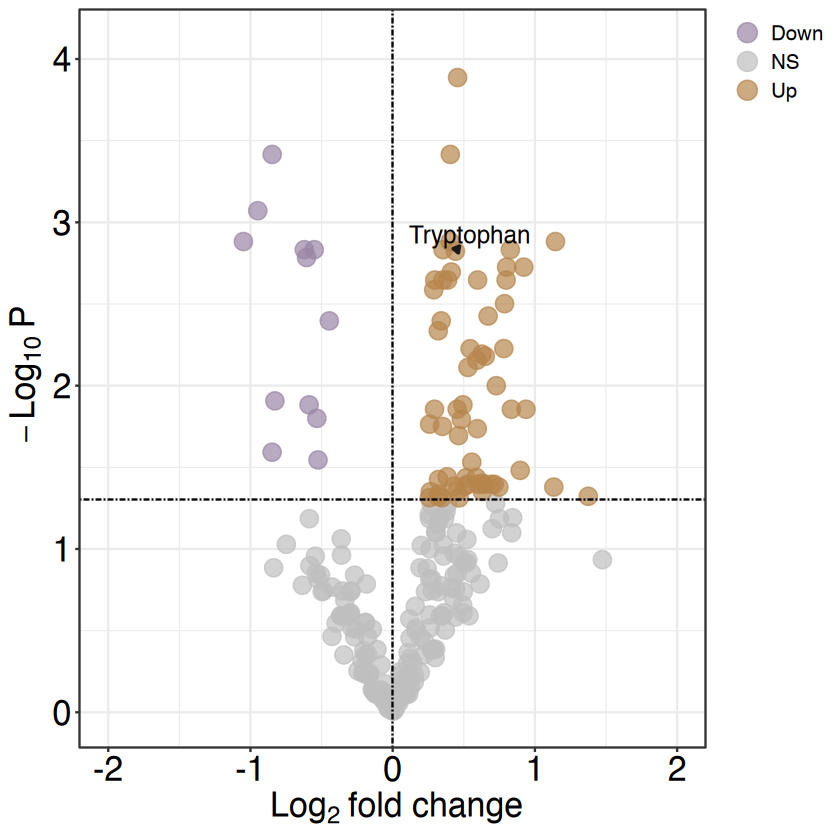

In [191]:
EnhancedVolcano(res2, 
    drawConnectors = T,
    lab = rownames(res2),
    selectLab = c('Tryptophan'),
    x = 'log2FoldChange',
    y = 'padj',
    xlim = c(-2, 2),
    ylim = c(-0.01, 4.1),
    title = NULL,
    cutoffLineType = 'blank',
    colCustom = names.keyvals,
    subtitle = NULL,
    colAlpha = 0.7,
    pCutoff = 0.05,
    FCcutoff = 0,
    borderWidth = 0.4,
    pointSize = 4.5,
    captionLabSize = 46,
    widthConnectors = 0.8,
    caption = NULL,
    labSize = 5.0)+
    theme_dose(20)+ 
    geom_hline(yintercept=-log10(0.05), linetype='twodash', col = 'black')+
    geom_vline(xintercept=0, linetype='twodash', col = 'black')+
    theme(legend.text=element_text(size=12), 
          legend.title = element_blank(), 
          legend.justification = c("right", "top"))

## Cell lines

In [192]:
data_cells <- read.csv("../Data/Cells_for_heatmap.csv", row.names = 1)

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“readTableHeader нашел неполную последнюю строку в '../Data/Cells_for_heatmap.csv'”


In [193]:
colnames(data_cells) <- c('ARPE19.Control_1', 
                    'ARPE19.Control_2', 
                    'ARPE19.Control_3', 
                    'ARPE19.Control_4', 
                    'ARPE19.SIRT6.KO_1', 
                    'ARPE19.SIRT6.KO_2', 
                    'ARPE19.SIRT6.KO_3', 
                    'ARPE19.SIRT6.KO_4', 
                    'HeLa.Control_1', 'HeLa.Control_2', 'HeLa.Control_3', 'HeLa.Control_4', 
                    'HeLa.SIRT6.KO_1', 'HeLa.SIRT6.KO_2', 'HeLa.SIRT6.KO_3', 'HeLa.SIRT6.KO_4', 
                    'SHSY5Y.Control_1', 'SHSY5Y.Control_2', 'SHSY5Y.Control_3', 'SHSY5Y.Control_4', 
                    'SHSY5Y.SIRT6.KO_1', 'SHSY5Y.SIRT6.KO_2', 'SHSY5Y.SIRT6.KO_3', 'SHSY5Y.SIRT6.KO_4')

In [194]:
meta <- data.frame(Cell = c(rep('ARPE19', 8), rep('HeLa', 8), rep('SHSY-5Y', 8)), 
                   Genotype = rep(c(rep('Ctrl', 4), rep('SIRT6 KO', 4)), 3))

In [195]:
rownames(meta) <- colnames(data_cells)

In [196]:
col_fun = colorRamp2(c(-1.5, 0, 1.5), c("steelblue", "white", "#D14f4f"))

ann_colors = list(
    Genotype = c(`SIRT6 KO` = 'darkred', `Ctrl` = 'steelblue')
) 

In [197]:
data_cells_scaled <- as.data.frame(scale(data_cells))

In [198]:
m1 <- meta[c(1:8), c(2), drop = F]
h1 <- Heatmap(matrix = as.matrix(data_cells_scaled[, c(1:8)]), cluster_rows = F,
              column_split = factor(m1$Genotype, levels = c('Control', 'SIRT6-KO')),
              column_title = 'ARPE19',
              name = "Scaled \nratios",
              show_row_names = T, 
              show_column_names = F, 
              cluster_columns = F,
              clustering_distance_rows = 'manhattan',
              rect_gp = gpar(col = "white", lwd = 0.05),
              row_gap = unit(2, "mm"),
              col = col_fun, 
              top_annotation = HeatmapAnnotation(df = m1, 
                                                 col = ann_colors, 
                                                 show_annotation_name = F, 
                                                 simple_anno_size = unit(0.15, "cm"))
             )

m2 <- meta[c(9:16), c(2), drop = F]
h2 <- Heatmap(matrix = as.matrix(data_cells_scaled[, c(9:16)]), cluster_rows = F,
              column_split = factor(m2$Genotype, levels = c('Control', 'SIRT6-KO')),
              column_title = 'HeLa',
              show_row_names = T, 
              show_column_names = F, 
              show_heatmap_legend = F,
              cluster_columns = F,
              clustering_distance_rows = 'manhattan',
              rect_gp = gpar(col = "white", lwd = 0.05),
              row_gap = unit(2, "mm"),
              col = col_fun, 
              top_annotation = HeatmapAnnotation(df = m2, 
                                                 col = ann_colors, 
                                                 show_annotation_name = F, 
                                                 simple_anno_size = unit(0.15, "cm"))
             )

m3 <- meta[c(17:24), c(2), drop = F]
h3 <- Heatmap(matrix = as.matrix(data_cells_scaled[, c(17:24)]), cluster_rows = F, 
              column_split = factor(m3$Genotype, levels = c('Control', 'SIRT6-KO')),
              column_title = 'SH-SY5Y',
              show_row_names = T, 
              show_column_names = F,
              show_heatmap_legend = F,
              cluster_columns = F,
              clustering_distance_rows = 'manhattan',
              rect_gp = gpar(col = "white", lwd = 0.05),
              row_gap = unit(2, "mm"),
              col = col_fun, 
              top_annotation = HeatmapAnnotation(df = m3, 
                                                 col = ann_colors, 
                                                 show_annotation_name = F, 
                                                 simple_anno_size = unit(0.15, "cm"))
             )

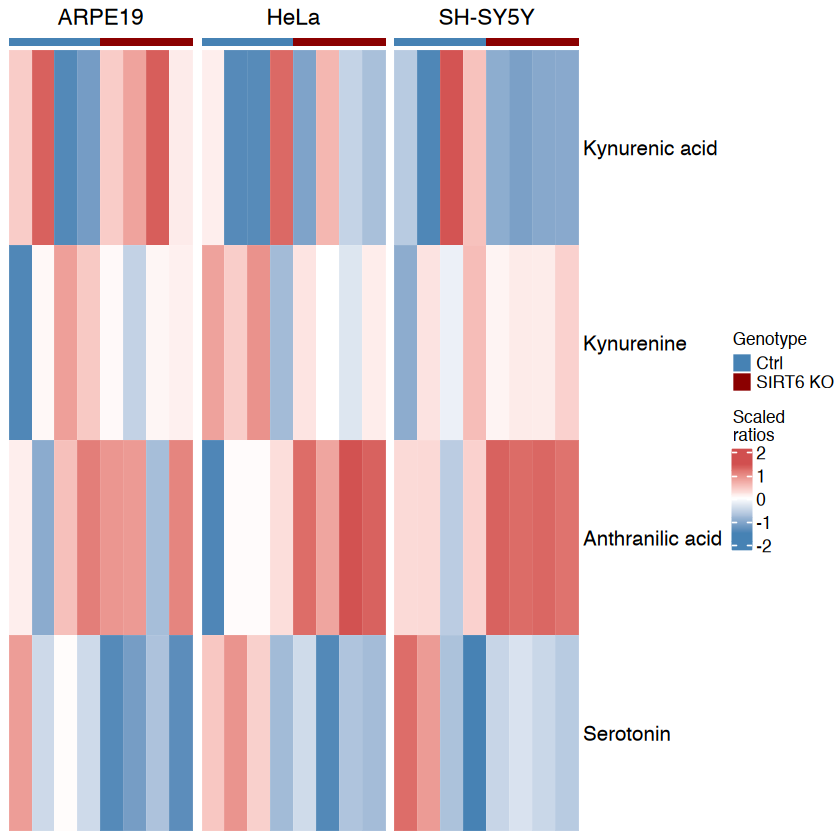

In [199]:
draw(h1 + h2 + h3, merge_legend = TRUE)

PCA

In [200]:
pca.res <- prcomp(t(data_cells), scale=T)

In [201]:
percentVar <- pca.res$sdev^2/sum(pca.res$sdev^2)
d1 <- data.frame(PC1 = pca.res$x[, 1], 
                 PC2 = pca.res$x[, 2], 
                 Genotype = meta$Genotype, 
                 Cell = meta$Cell
                )

In [202]:
d1$Genotype <- factor(d1$Genotype, levels = c("Ctrl", "SIRT6 KO"))

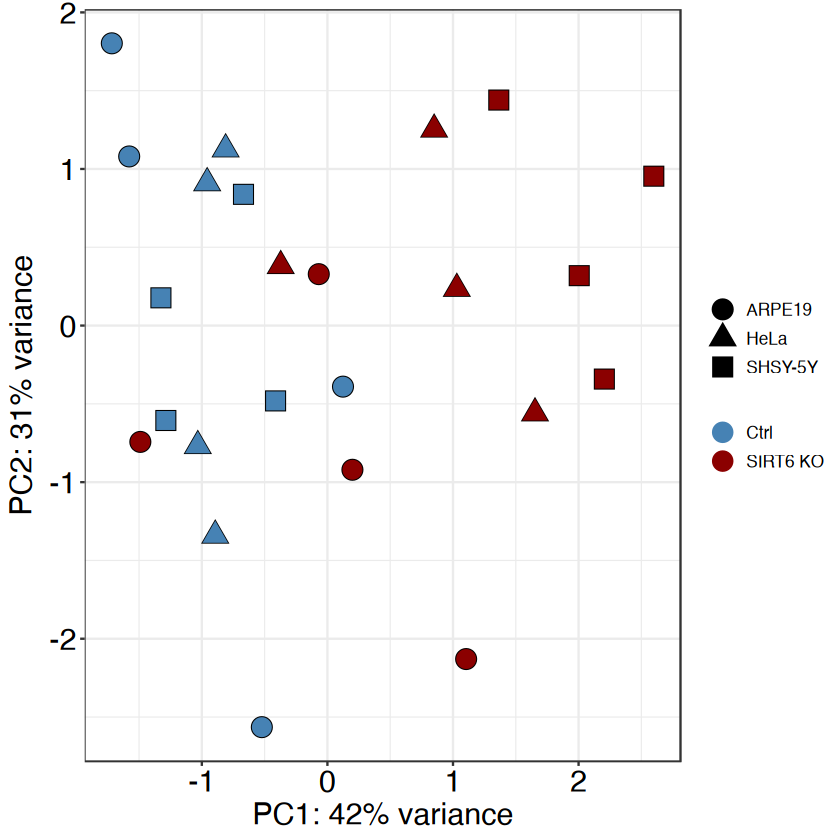

In [203]:
ggplot(data = d1, aes_string(x = "PC1", y = "PC2")) +
        geom_point(aes_string(shape = "Cell"), color = "black", size = 5.6) +
        geom_point(aes_string(color = "Genotype", shape = "Cell"), size = 5) + 
        scale_color_manual(values=c("steelblue", "#8b0000"))+
        scale_fill_manual(values=c("steelblue", "#8b0000"))+
        xlab(paste0("PC1: ", round(percentVar[1] * 100), "% variance")) + 
        ylab(paste0("PC2: ", round(percentVar[2] * 100), "% variance")) +
        theme_dose(font.size = 18)+
        theme(legend.key = element_rect(colour = NA, fill = NA), 
              legend.title = element_blank(), 
              legend.text = element_text(size=10))

Individual groups

In [204]:
meta.arpe19 <- meta[meta$Cell == 'ARPE19', ]
meta.shsy5y <- meta[meta$Cell == 'SHSY-5Y', ]
meta.hela <- meta[meta$Cell == 'HeLa', ]

In [205]:
data.arpe19 <- data_cells[, meta$Cell == 'ARPE19']
data.shsy5y <- data_cells[, meta$Cell == 'SHSY-5Y']
data.hela <- data_cells[, meta$Cell == 'HeLa']

In [206]:
pca.shsy5y <- prcomp(t(data.shsy5y), scale=TRUE)
pca.hela <- prcomp(t(data.hela), scale=TRUE)
pca.arpe19 <- prcomp(t(data.arpe19), scale=TRUE)

In [207]:
percentVar.shsy5y <- pca.shsy5y$sdev^2/sum(pca.shsy5y$sdev^2)
d1.shsy5y <- data.frame(PC1 = pca.shsy5y$x[, 1], 
                 PC2 = pca.shsy5y$x[, 2], 
                 Genotype = meta.shsy5y$Genotype, 
                 Cell = meta.shsy5y$Cell
                )

percentVar.hela <- pca.hela$sdev^2/sum(pca.hela$sdev^2)
d1.hela <- data.frame(PC1 = pca.hela$x[, 1], 
                 PC2 = pca.hela$x[, 2], 
                 Genotype = meta.hela$Genotype, 
                 Cell = meta.hela$Cell
                )

percentVar.arpe19 <- pca.arpe19$sdev^2/sum(pca.arpe19$sdev^2)
d1.arpe19 <- data.frame(PC1 = pca.arpe19$x[, 1], 
                 PC2 = pca.arpe19$x[, 2], 
                 Genotype = meta.arpe19$Genotype, 
                 Cell = meta.arpe19$Cell
                )

In [208]:
d1.shsy5y$Genotype <- factor(d1.shsy5y$Genotype, levels = c("Ctrl", "SIRT6 KO"))
d1.hela$Genotype <- factor(d1.hela$Genotype, levels = c("Ctrl", "SIRT6 KO"))
d1.arpe19$Genotype <- factor(d1.arpe19$Genotype, levels = c("Ctrl", "SIRT6 KO"))

In [209]:
p1 <- ggplot(data = d1.shsy5y, aes_string(x = "PC1", y = "PC2")) +
        geom_point(color = "black", size = 5.6) +
        geom_point(aes_string(color = "Genotype"), size = 5) + 
        scale_color_manual(values=c("steelblue", "#8b0000"))+
        scale_fill_manual(values=c("steelblue", "#8b0000"))+
        xlab(paste0("PC1: ", round(percentVar.shsy5y[1] * 100), "% variance")) + 
        ylab(paste0("PC2: ", round(percentVar.shsy5y[2] * 100), "% variance")) +
        stat_ellipse(aes(fill = Genotype), geom = "polygon", alpha = 0.2)+
        ylim(-5, 5)+
        ggtitle("SHSY-5Y") +
        theme_dose(font.size = 18)+
        theme(plot.title = element_text(size = 16),
              legend.key = element_rect(colour = NA, fill = NA), 
              legend.title = element_blank(), 
              legend.text = element_text(size=12))


p2 <- ggplot(data = d1.hela, aes_string(x = "PC1", y = "PC2")) +
        geom_point(color = "black", size = 5.6) +
        geom_point(aes_string(color = "Genotype"), size = 5) + 
        scale_color_manual(values=c("steelblue", "#8b0000"))+
        scale_fill_manual(values=c("steelblue", "#8b0000"))+
        xlab(paste0("PC1: ", round(percentVar.hela[1] * 100), "% variance")) + 
        ylab(paste0("PC2: ", round(percentVar.hela[2] * 100), "% variance")) +
        stat_ellipse(aes(fill = Genotype), geom = "polygon", alpha = 0.2)+
        xlim(-5, 5)+
        ggtitle("HeLa") +
        theme_dose(font.size = 18)+
        theme(plot.title = element_text(size = 16),#legend.position= c(0.22, 0.87), 
              legend.key = element_rect(colour = NA, fill = NA), 
              legend.title = element_blank(), 
              legend.text = element_text(size=10))


p3 <- ggplot(data = d1.arpe19, aes_string(x = "PC1", y = "PC2")) +
        geom_point(color = "black", size = 5.6) +
        geom_point(aes_string(color = "Genotype"), size = 5) +
        scale_color_manual(values=c("steelblue", "#8b0000"))+
        scale_fill_manual(values=c("steelblue", "#8b0000"))+
        xlab(paste0("PC1: ", round(percentVar.arpe19[1] * 100), "% variance")) + 
        ylab(paste0("PC2: ", round(percentVar.arpe19[2] * 100), "% variance")) +
        stat_ellipse(aes(fill = Genotype), geom = "polygon", alpha = 0.2)+
        xlim(-5, 5)+
        ylim(-7.5, 5)+
        ggtitle("ARPE19") +
        theme_dose(font.size = 18)+
        theme(plot.title = element_text(size = 16), 
              legend.key = element_rect(colour = NA, fill = NA), 
              legend.title = element_blank(), 
              legend.text = element_text(size=10))


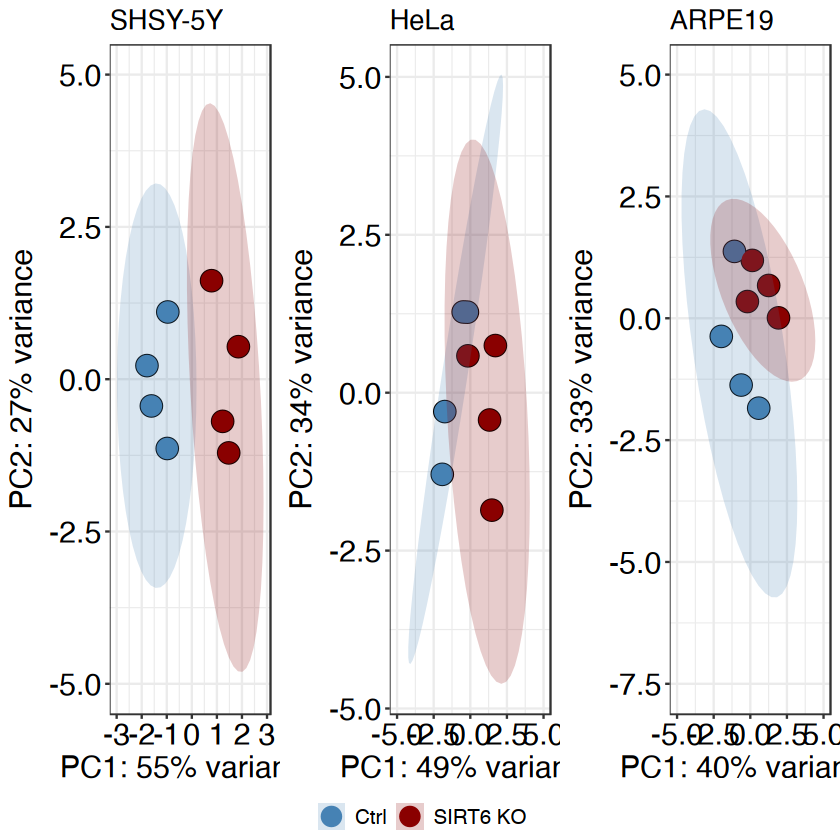

In [210]:
ggarrange(p1, p2, p3, ncol = 3, nrow = 1, common.legend = T, legend = 'bottom', align = 'hv')

## SH-SY5Y 2nd dataset

In [211]:
shsy5y_data.log <- read.csv('../Data/shsy5y.data.log2.csv', row.names = 1)

In [212]:
meta <- data.frame(Genotype = c(rep('WT', 4), rep('SIRT6-KO', 4)), row.names = colnames(shsy5y_data.log))

In [213]:
pca.res <- prcomp(t(shsy5y_data.log), scale = TRUE)

In [214]:
percentVar <- pca.res$sdev^2/sum(pca.res$sdev^2)
d1 <- data.frame(PC1 = pca.res$x[, 1], PC2 = pca.res$x[, 2], Genotype = c(rep('WT', 4), rep('S6KO', 4)))

In [215]:
d1$Genotype <- factor(d1$Genotype, levels = c("WT", "S6KO"))

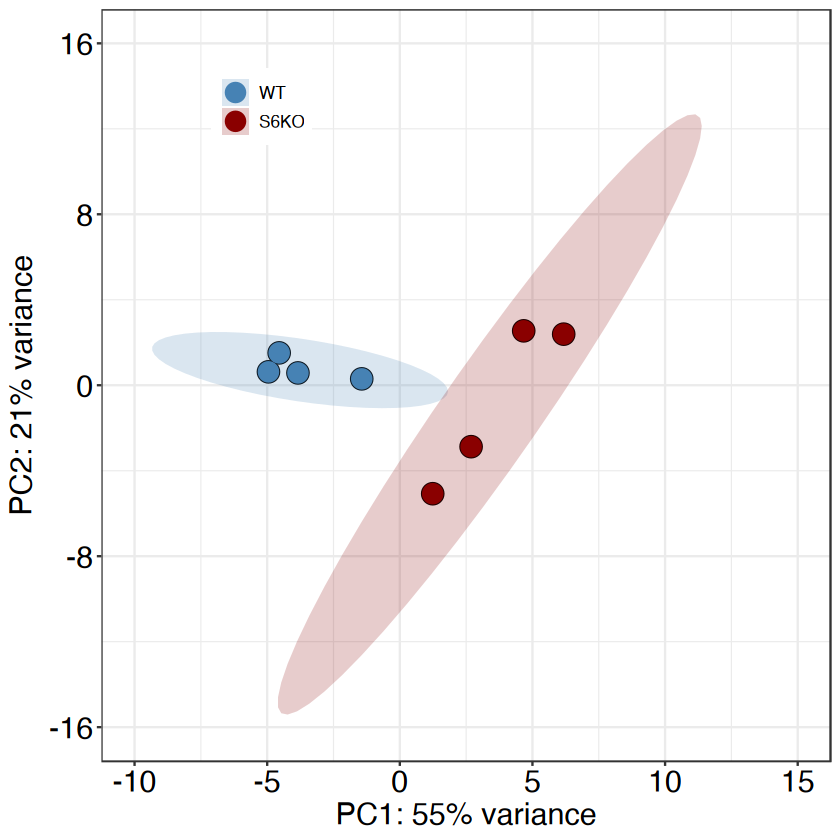

In [216]:
ggplot(data = d1, aes_string(x = "PC1", y = "PC2")) +
        geom_point(color = "black", size = 5.6) +
        geom_point(aes_string(color = "Genotype"), size = 5) + 
        scale_color_manual(values=c("steelblue", "#8b0000"))+
        scale_fill_manual(values=c("steelblue", "#8b0000"))+
        xlab(paste0("PC1: ", round(percentVar[1] * 100), "% variance")) + 
        ylab(paste0("PC2: ", round(percentVar[2] * 100), "% variance")) +
        stat_ellipse(aes(fill = Genotype), geom = "polygon", alpha = 0.2)+
        xlim(-10, 15)+
        scale_y_continuous(limits = c(-16, 16), breaks = c(-16, -8, 0, 8, 16))+
        theme_dose(font.size = 18)+
        theme(legend.position= c(0.22, 0.87), 
              legend.key = element_rect(colour = NA, fill = NA), 
              legend.title = element_blank(), 
              legend.text = element_text(size=10))

Volcano plot

In [217]:
data.norm <- read.csv('../Data/shsy5y.data.norm.csv', row.names = 1)

In [218]:
data.norm <- as.data.frame(t(data.norm))

In [219]:
p.values <- apply(data.norm, 2, function(r) {
    t.test(r[c(1:4)], r[c(5:8)])$p.value
})

In [220]:
min(p.adjust(p.values, method = "fdr"))

[1] 0.01367465

In [221]:
sig.table <- as.data.frame(p.adjust(p.values, method = "fdr"))
colnames(sig.table) <- 'padj'

In [222]:
l2fc <- apply(data.norm, 2, function(r) {
    log2(mean(r[c(5:8)])) - log2(mean(r[c(1:4)]))
})

In [223]:
sig.table$LFC <- l2fc

In [224]:
sig.table$Sig <- 'NS'
sig.table[((sig.table$padj < 0.05) & (sig.table$LFC < 0)), c(3)] <- 'Down'
sig.table[((sig.table$padj < 0.05) & (sig.table$LFC > 0)), c(3)] <- 'Up'

In [225]:
names.keyvals <- sig.table$Sig
names.keyvals[names.keyvals == 'NS'] <- 'grey'
names.keyvals[names.keyvals == 'Down'] <- wes_palette("IsleofDogs1")[1]
names.keyvals[names.keyvals == 'Up'] <- wes_palette("IsleofDogs2")[3]
names(names.keyvals) <- sig.table$Sig

In [226]:
name.map <- read.csv('../Data/shsy5y.name_map.csv')
names <- name.map$Match
names <- replace(names, names=="L-Tryptophan", "Tryptophan")
sig.table$Match <- names

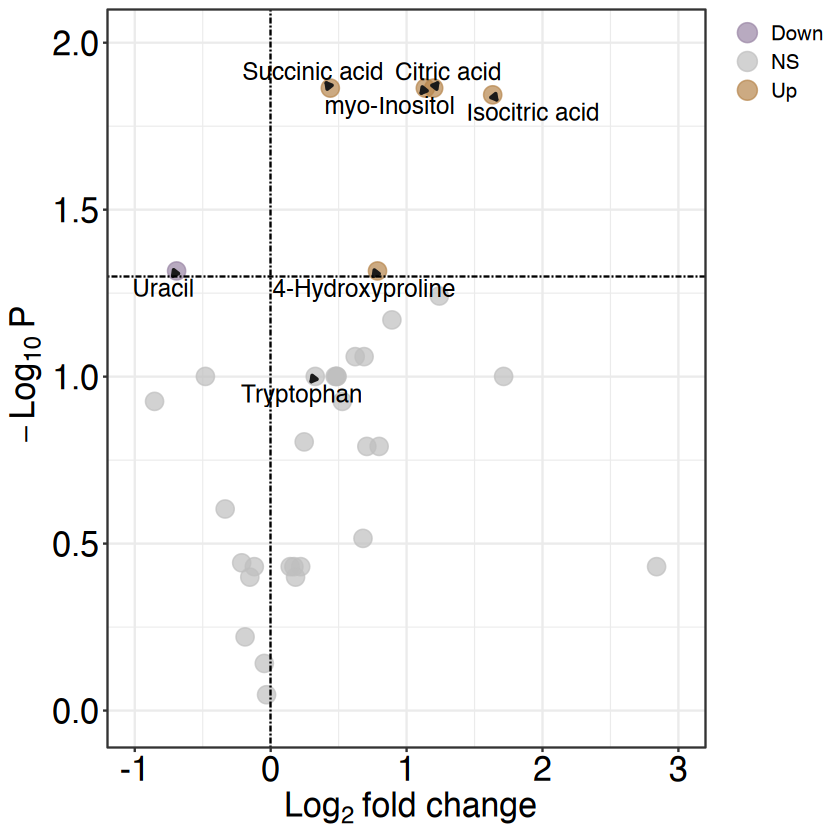

In [227]:
EnhancedVolcano(sig.table, drawConnectors = T, 
    lab = sig.table$Match,
    selectLab = c('Succinic acid', 'Uracil', '4-Hydroxyproline', 'Citric acid', 
                  'Isocitric acid', 'myo-Inositol', 'Tryptophan'),
    x = 'LFC',
    y = 'padj',
    xlim = c(-1, 3),
    ylim = c(-0.01, 2),
    title = NULL,
    cutoffLineType = 'blank',
    colCustom = names.keyvals,
    subtitle = NULL,
    colAlpha = 0.7,
    pCutoff = 0.05,
    FCcutoff = 0,
    borderWidth = 0.4,
    pointSize = 4.5,
    captionLabSize = 46,
    widthConnectors = 0.8,
    caption = NULL,
    labSize = 5.0)+
    theme_dose(20)+ 
    geom_hline(yintercept=-log10(0.05), linetype='twodash', col = 'black')+
    geom_vline(xintercept=0, linetype='twodash', col = 'black')+
    theme(legend.text=element_text(size=12), 
          legend.title = element_blank(), 
          legend.justification = c("right", "top"))

In [228]:
sessionInfo()

R version 4.4.1 (2024-06-14)
Platform: aarch64-apple-darwin20
Running under: macOS Sonoma 14.5

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.12.0

locale:
[1] ru_RU.UTF-8/ru_RU.UTF-8/ru_RU.UTF-8/C/ru_RU.UTF-8/ru_RU.UTF-8

time zone: Europe/Moscow
tzcode source: internal

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggpubr_0.6.0           circlize_0.4.16        ComplexHeatmap_2.20.0 
 [4] RColorBrewer_1.1-3     factoextra_1.0.7       corrplot_0.94         
 [7] ggforce_0.4.2          stringr_1.5.1          preprocessCore_1.66.0 
[10] EnhancedVolcano_1.22.0 ggrepel_0.9.6          pheatmap_1.0.12       
[13] wesanderson_0.3.7      DOSE_3.30.5            tibble_3.3.0          
[16] ggplot2_3.5.2          dplyr_1.1.4 